Problem description:
<br>
Predicting whether a customer will change telecommunications provider, something known as "churning".
<br>
Dataset info:
<br>
The training dataset contains 4250 samples. Each sample contains 19 features and 1 boolean variable "churn" which indicates the class of the sample. The 19 input features and 1 target variable are:

- "state", string. 2-letter code of the US state of customer residence
- "account_length", numerical. Number of months the customer has been with the current telco provider
- "area_code", string="area_code_AAA" where AAA = 3 digit area code.
- "international_plan", (yes/no). The customer has international plan.
- "voice_mail_plan", (yes/no). The customer has voice mail plan.
- "number_vmail_messages", numerical. Number of voice-mail messages.
- "total_day_minutes", numerical. Total minutes of day calls.
- "total_day_calls", numerical. Total minutes of day calls.
- "total_day_charge", numerical. Total charge of day calls.
- "total_eve_minutes", numerical. Total minutes of evening calls.
- "total_eve_calls", numerical. Total number of evening calls.
- "total_eve_charge", numerical. Total charge of evening calls.
- "total_night_minutes", numerical. Total minutes of night calls.
- "total_night_calls", numerical. Total number of night calls.
- "total_night_charge", numerical. Total charge of night calls.
- "total_intl_minutes", numerical. Total minutes of international calls.
- "total_intl_calls", numerical. Total number of international calls.
- "total_intl_charge", numerical. Total charge of international calls
- "number_customer_service_calls", numerical. Number of calls to customer service
- "churn", (yes/no). Customer churn - target variable.


Your task is to : 
  1. Use some EDA techniques we learned this week   
  2. Using Univariate variable analysis: 
    Hint : use dataframe['feature'].unique()
  3. Fix the problems on the features above 
      - hint : Use df.replace from pandas, and df.apply
  4. Detect skewed distribution on a numeric variable :
      - Use log/sqrt transformation on at least one variable with skewed distribution
      - hint : use np.log() or np.sqrt()
  5. Detect missing values and handle them

  6. Perform Bivariate analysis for feature selection.
  
  7. Scale the numeric data (some of them)
  
  8. KFold Cross validation, k = 5

  9. Train the model

  10. Evaluate the model
  
  11. Write a summary :
    - Which model gives the best result?
    - What can we improve in the future?
    - Which encoding give better performance on this dataset (CatBoost or One-Hot)?
----------------------------
General Support : 
For converting feature to numeric value use :
pd.to_numeric(dataset[feature], errors='coerce')

In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.svm import SVC

RANDOM_STATE = 42

In [2]:
org_df = pd.read_csv('dataset-workshop4.csv')
df = org_df.copy()
# df = copy.deepcopy(org_df)

In [3]:
df.describe()

account_length  number_vmail_messages  total_day_minutes  \
count     4250.000000            4250.000000        4250.000000   
mean       100.236235               7.631765         180.259600   
std         39.698401              13.439882          54.012373   
min          1.000000               0.000000           0.000000   
25%         73.000000               0.000000         143.325000   
50%        100.000000               0.000000         180.450000   
75%        127.000000              16.000000         216.200000   
max        243.000000              52.000000         351.500000   

       total_day_calls  total_day_charge  total_eve_minutes  total_eve_calls  \
count      4250.000000       4250.000000        4250.000000      4250.000000   
mean         99.907294         30.644682         200.173906       100.176471   
std          19.850817          9.182096          50.249518        19.908591   
min           0.000000          0.000000           0.000000         0.000000   
25%          87.000000         24.365000         165.925000        87.000000   
50%         100.000000         30.680000         200.700000       100.000000   
75%         113.000000         36.750000         233.775000       114.000000   
max         165.000000         59.760000         359.300000       170.000000   

       total_eve_charge  total_night_minutes  total_night_calls  \
count       4250.000000          4250.000000        4250.000000   
mean          17.015012           200.527882          99.839529   
std            4.271212            50.353548          20.093220   
min            0.000000             0.000000           0.000000   
25%           14.102500           167.225000          86.000000   
50%           17.060000           200.450000         100.000000   
75%           19.867500           234.700000         113.000000   
max           30.540000           395.000000         175.000000   

       total_night_charge  total_intl_minutes  total_intl_calls  \
count         4250.000000         4250.000000       4250.000000   
mean             9.023892           10.256071          4.426353   
std              2.265922            2.760102          2.463069   
min              0.000000            0.000000          0.000000   
25%              7.522500            8.500000          3.000000   
50%              9.020000           10.300000          4.000000   
75%             10.560000           12.000000          6.000000   
max             17.770000           20.000000         20.000000   

       total_intl_charge  number_customer_service_calls  
count        4250.000000                    4250.000000  
mean            2.769654                       1.559059  
std             0.745204                       1.311434  
min             0.000000                       0.000000  
25%             2.300000                       1.000000  
50%             2.780000                       1.000000  
75%             3.240000                       2.000000  
max             5.400000                       9.000000

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4250 entries, 0 to 4249
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   state                          4250 non-null   object 
 1   account_length                 4250 non-null   int64  
 2   area_code                      4250 non-null   object 
 3   international_plan             4250 non-null   object 
 4   voice_mail_plan                4250 non-null   object 
 5   number_vmail_messages          4250 non-null   int64  
 6   total_day_minutes              4250 non-null   float64
 7   total_day_calls                4250 non-null   int64  
 8   total_day_charge               4250 non-null   float64
 9   total_eve_minutes              4250 non-null   float64
 10  total_eve_calls                4250 non-null   int64  
 11  total_eve_charge               4250 non-null   float64
 12  total_night_minutes            4250 non-null   f

In [5]:
cat_cols = ['state', 'area_code', 'international_plan', 'voice_mail_plan', 'churn']
for c in cat_cols:
    df[c] = pd.Series(LabelEncoder().fit_transform(df[c]), dtype='category')

In [6]:
df

state  account_length area_code international_plan voice_mail_plan  \
0       35             107         1                  0               1   
1       31             137         1                  0               0   
2       35              84         0                  1               0   
3       36              75         1                  1               0   
4       19             121         2                  0               1   
...    ...             ...       ...                ...             ...   
4245    26              83         1                  0               0   
4246    49              73         0                  0               0   
4247    27              75         0                  0               0   
4248    11              50         0                  0               1   
4249    46              86         1                  0               1   

      number_vmail_messages  total_day_minutes  total_day_calls  \
0                        26              161.6              123   
1                         0              243.4              114   
2                         0              299.4               71   
3                         0              166.7              113   
4                        24              218.2               88   
...                     ...                ...              ...   
4245                      0              188.3               70   
4246                      0              177.9               89   
4247                      0              170.7              101   
4248                     40              235.7              127   
4249                     34              129.4              102   

      total_day_charge  total_eve_minutes  total_eve_calls  total_eve_charge  \
0                27.47              195.5              103             16.62   
1                41.38              121.2              110             10.30   
2                50.90               61.9               88              5.26   
3                28.34              148.3              122             12.61   
4                37.09              348.5              108             29.62   
...                ...                ...              ...               ...   
4245             32.01              243.8               88             20.72   
4246             30.24              131.2               82             11.15   
4247             29.02              193.1              126             16.41   
4248             40.07              223.0              126             18.96   
4249             22.00              267.1              104             22.70   

      total_night_minutes  total_night_calls  total_night_charge  \
0                   254.4                103               11.45   
1                   162.6                104                7.32   
2                   196.9                 89                8.86   
3                   186.9                121                8.41   
4                   212.6                118                9.57   
...                   ...                ...                 ...   
4245                213.7                 79                9.62   
4246                186.2                 89                8.38   
4247                129.1                104                5.81   
4248                297.5                116               13.39   
4249                154.8                100                6.97   

      total_intl_minutes  total_intl_calls  total_intl_charge  \
0                   13.7                 3               3.70   
1                   12.2                 5               3.29   
2                    6.6                 7               1.78   
3                   10.1                 3               2.73   
4                    7.5                 7               2.03   
...                  ...               ...                ...   
4245                10.3                 6               2.78   
4

IndexError: index 10 is out of bounds for axis 0 with size 10

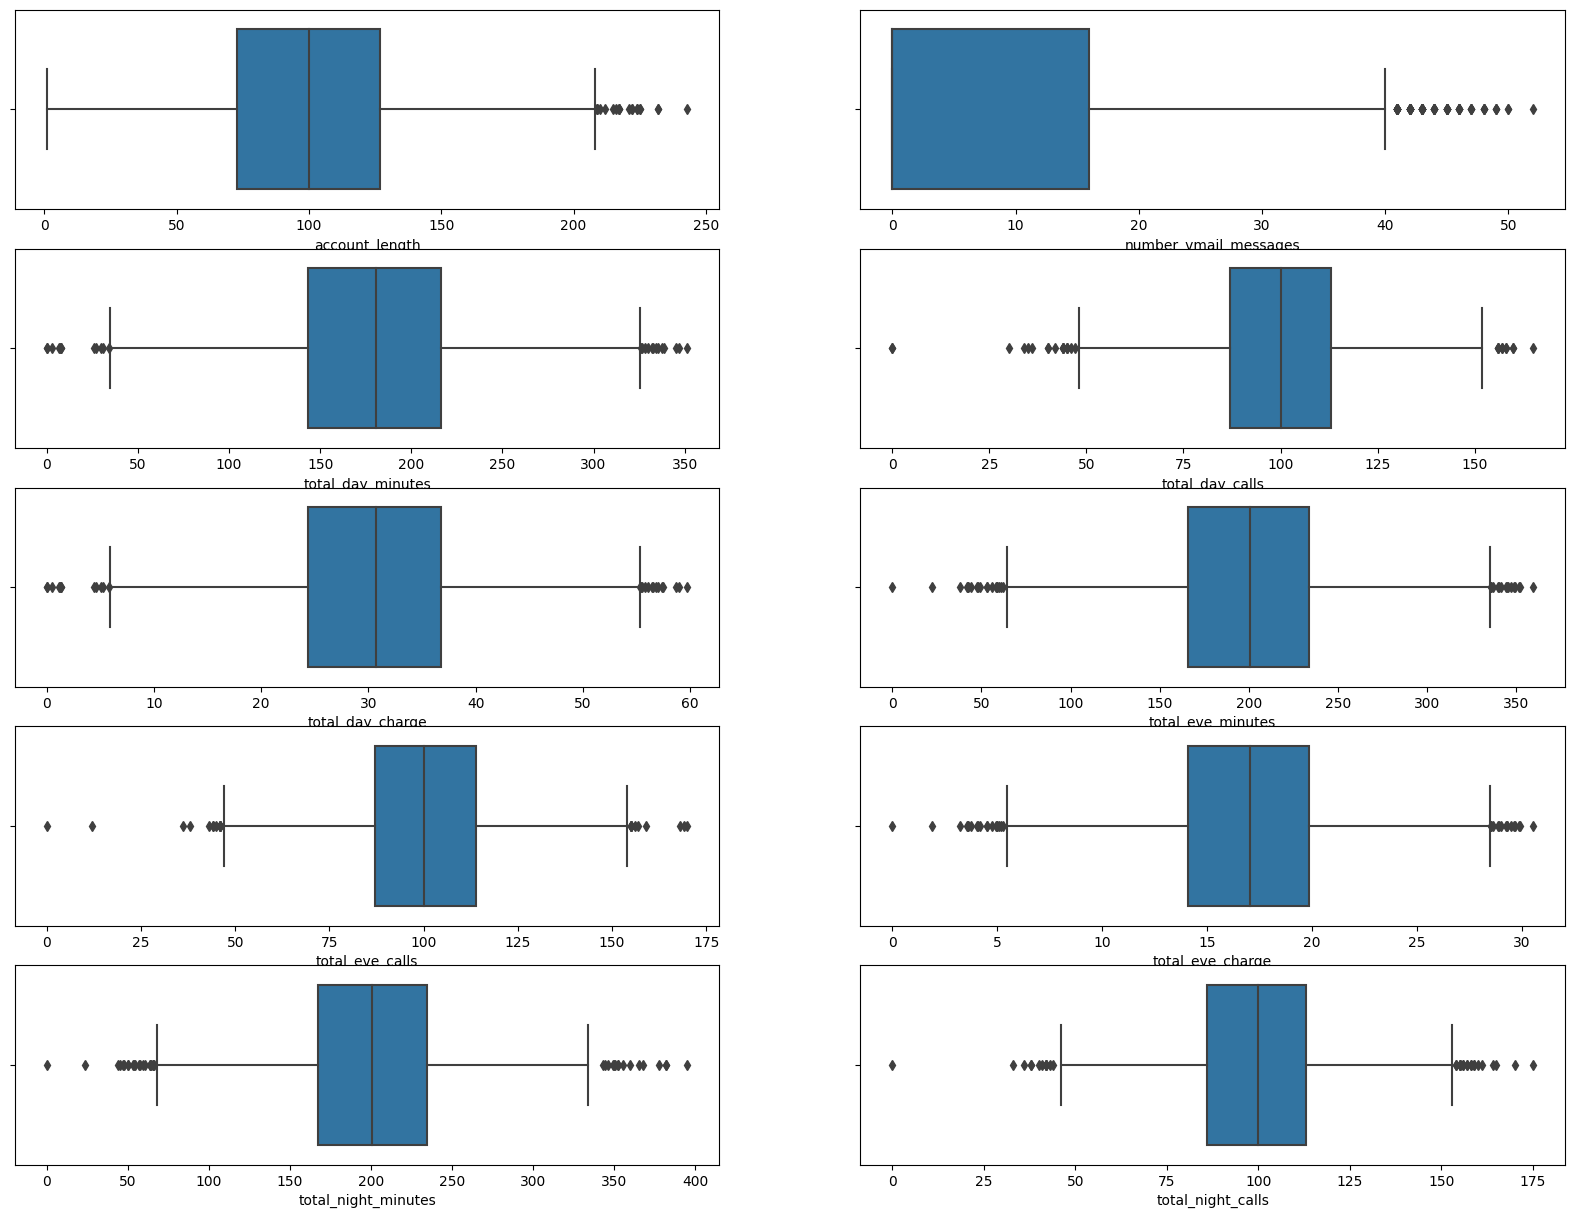

In [7]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(20, 15))
axs = axs.ravel()

for i, c in enumerate([el for el in df.columns if pd.api.types.is_numeric_dtype(df[el])]):
    sns.boxplot(df, x=c, orient='h', ax = axs[i])

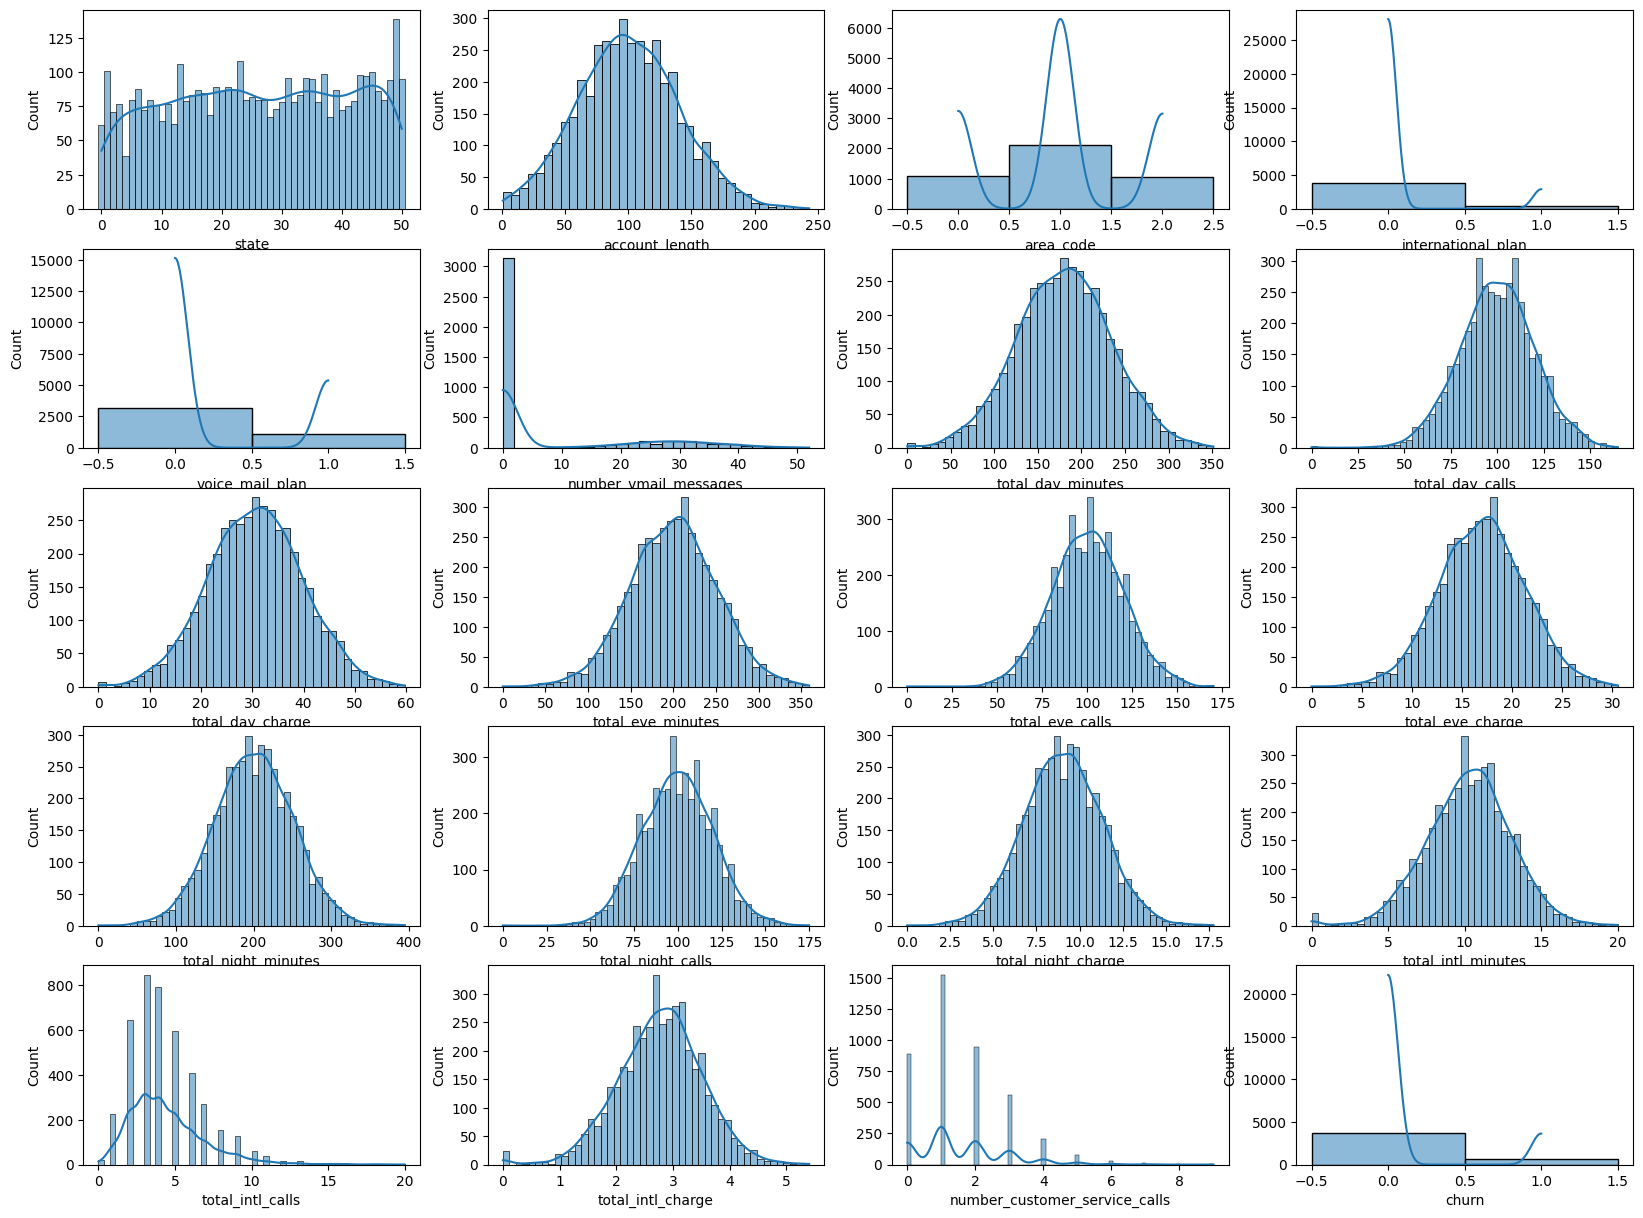

In [8]:
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(20, 15))
axs = axs.ravel()
for i, c in enumerate(df.columns):
    sns.histplot(df, x=c, ax = axs[i], kde=True)

<AxesSubplot: >

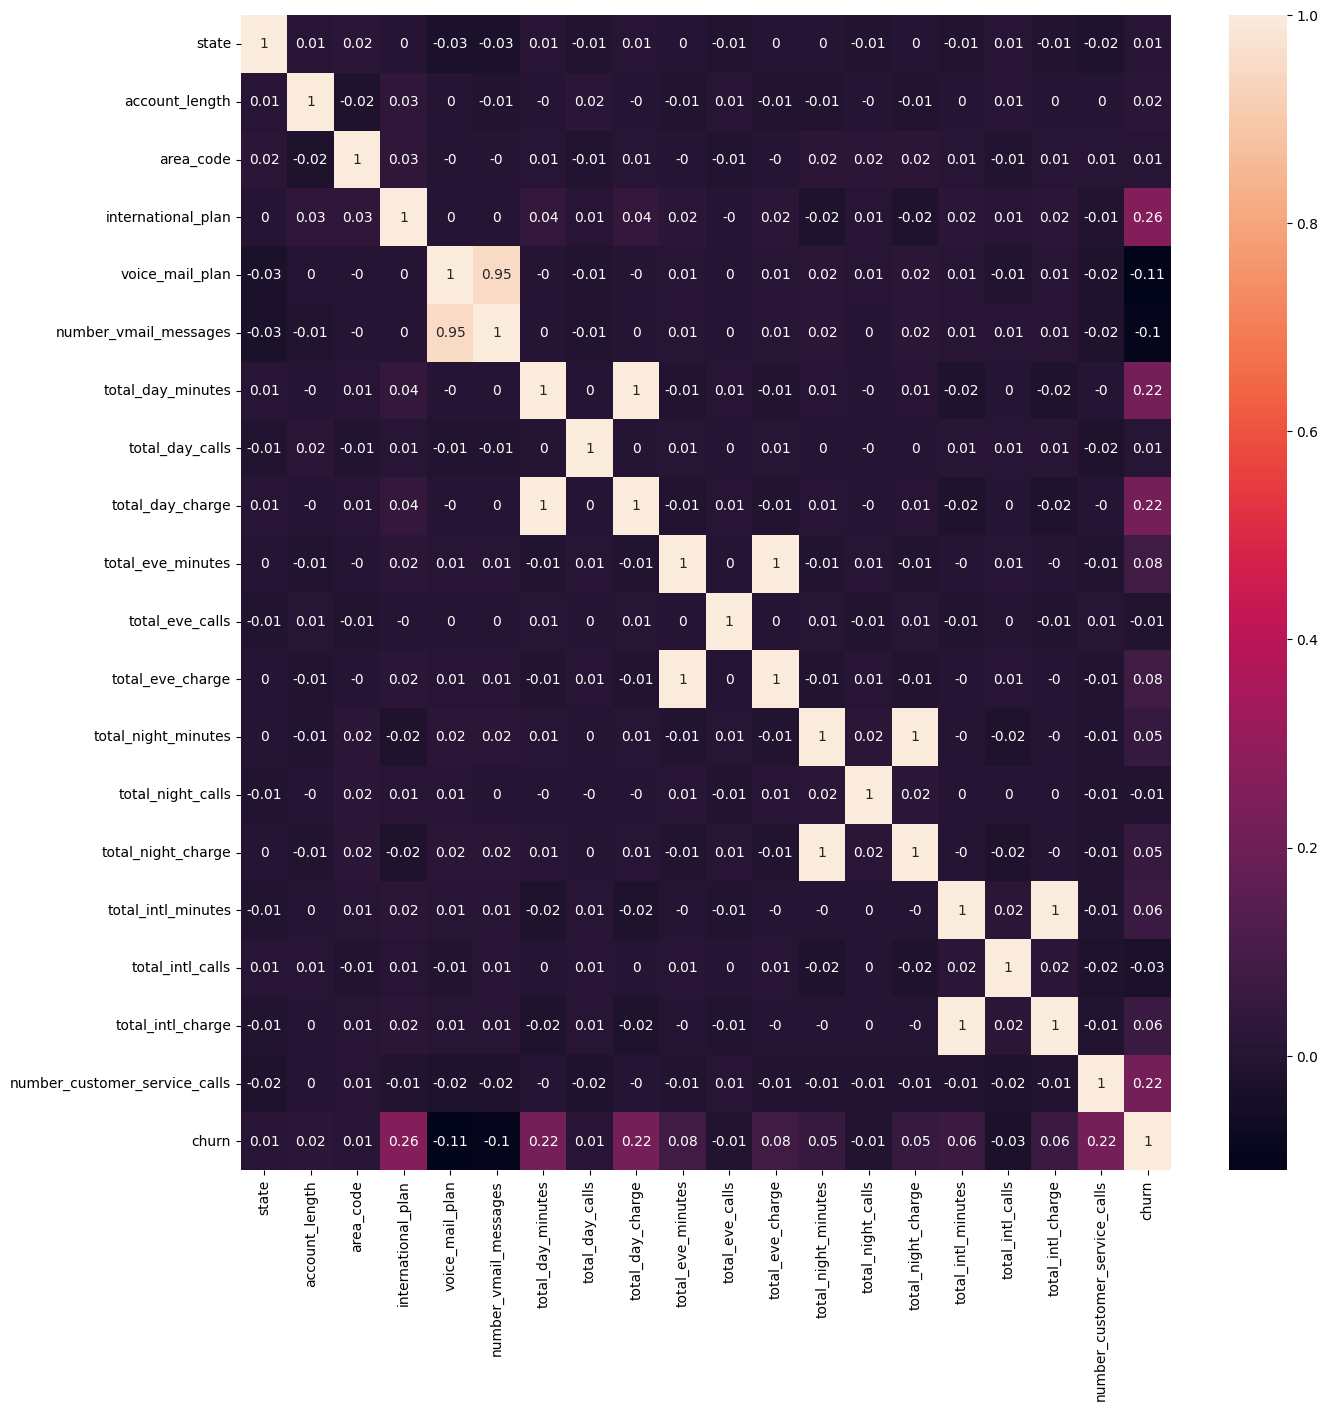

In [9]:
plt.figure(figsize=(15, 15))
p_corr = df.corr(numeric_only=False, method='pearson')
p_corr=p_corr.round(decimals=2)
sns.heatmap(p_corr, annot=True)

<AxesSubplot: >

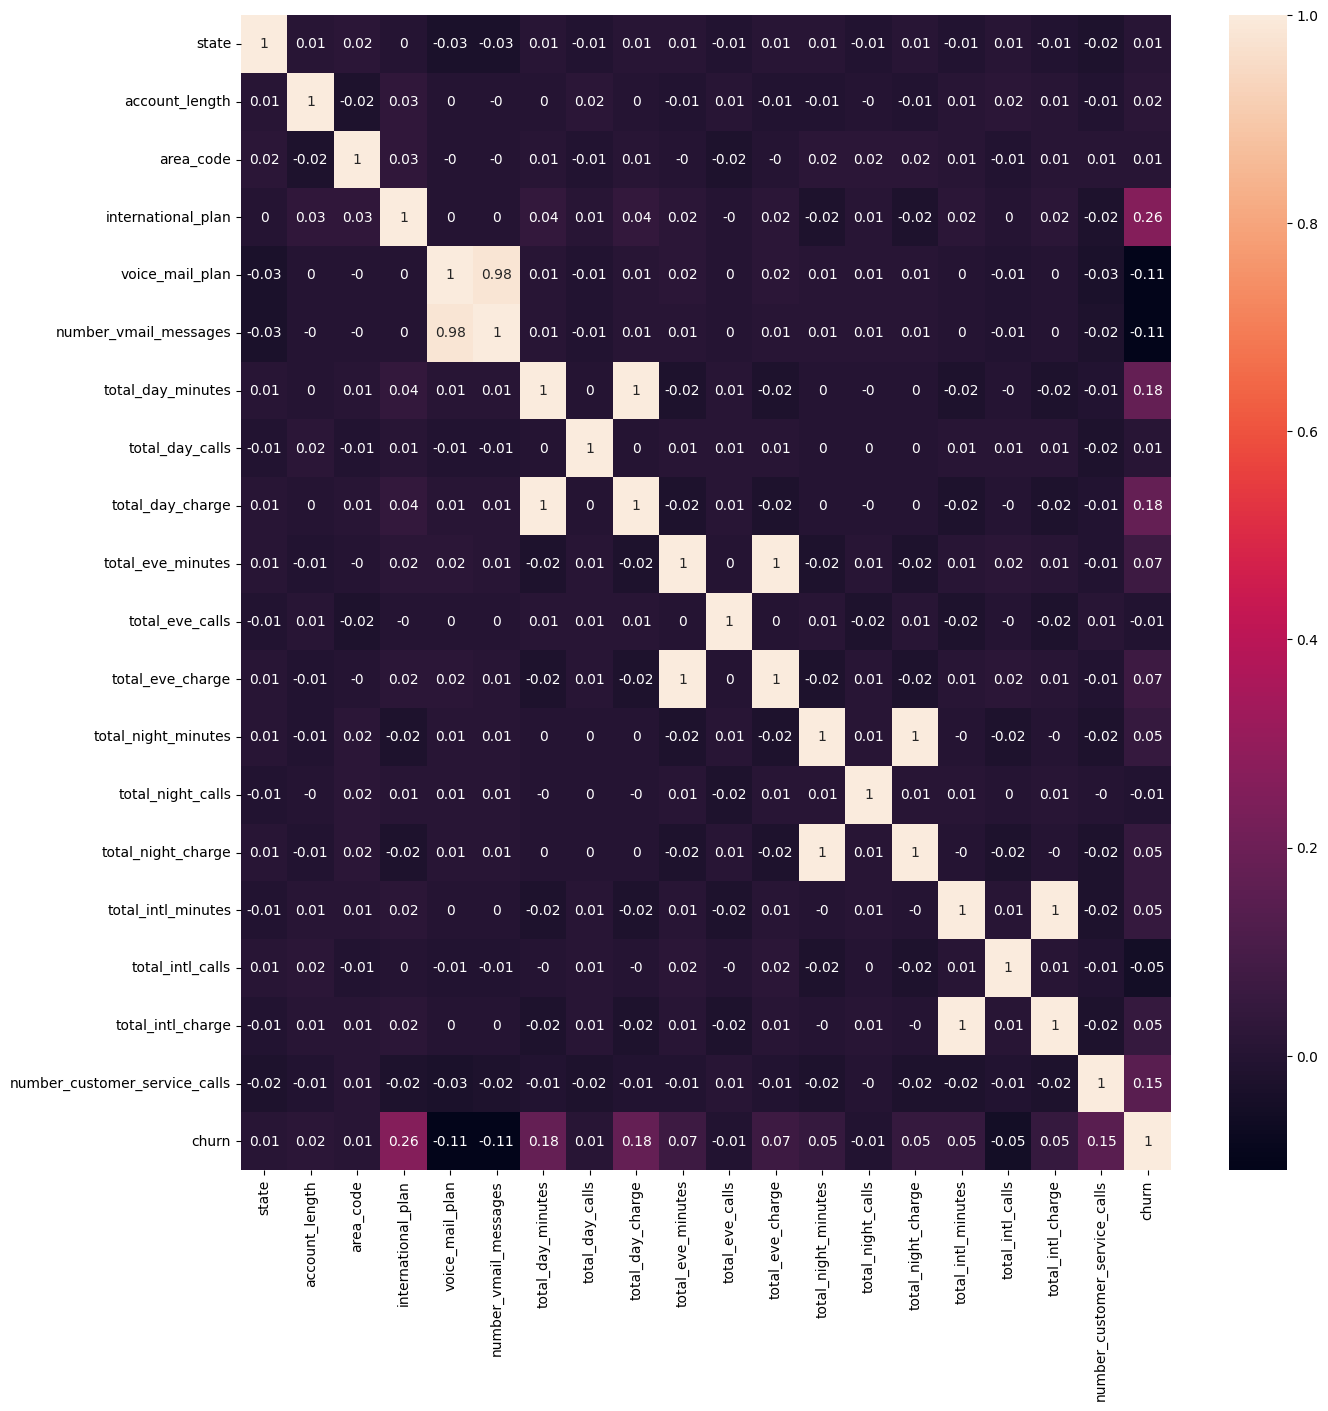

In [10]:
## SPEARMAN
plt.figure(figsize=(15, 15))
s_corr = df.corr(numeric_only=False, method='spearman')
s_corr=s_corr.round(decimals=2)
sns.heatmap(s_corr, annot=True)

In [11]:
# first BIVARIATE ANALYSIS observations and conclusions:
# - drop highly(>0.9) correlated features
cols_to_drop = ['number_vmail_messages', 'total_day_charge', 'total_eve_charge', 'total_night_charge', 'total_intl_charge']
df.drop(columns=cols_to_drop, inplace=True)

In [ ]:
## TO VERIFY CORRELATIONS
# plt.figure(figsize=(15, 15))
# p_corr = df.corr(numeric_only=False, method='pearson')
# p_corr=p_corr.round(decimals=2)
# sns.heatmap(p_corr, annot=True)

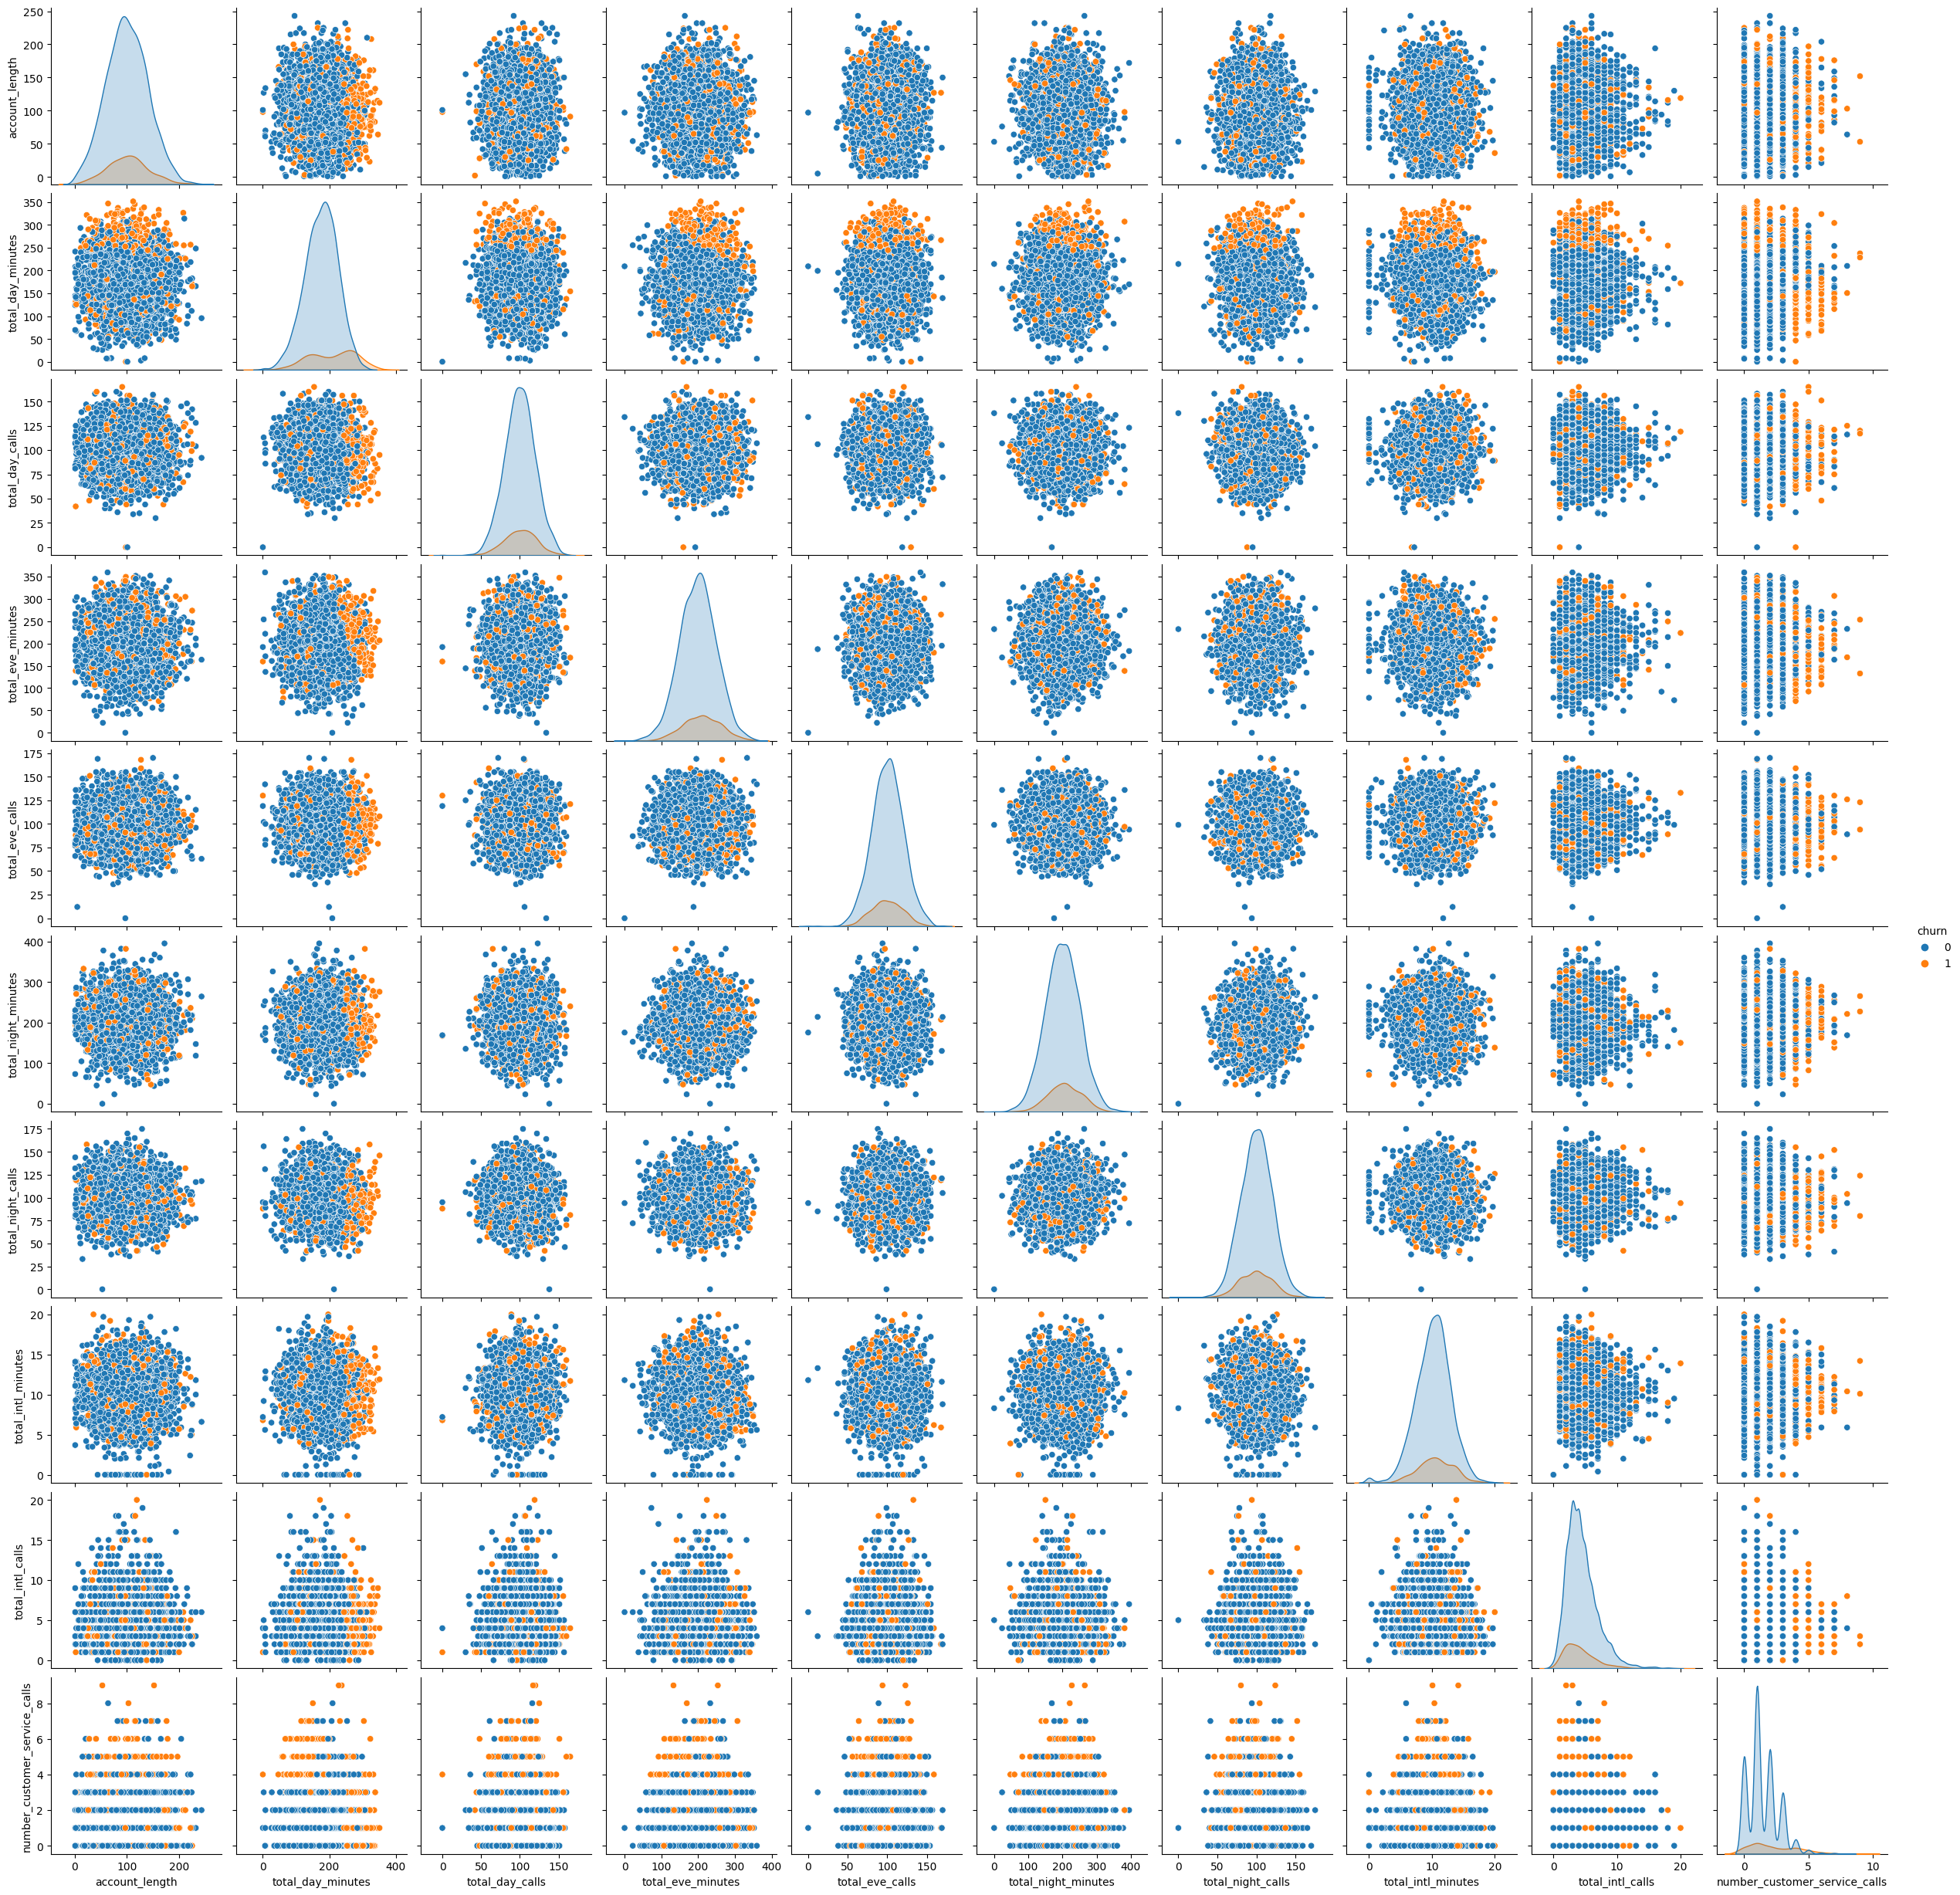

In [ ]:
# df['international_plan'] = df['international_plan'].astype(int)
sns.pairplot(df, hue='churn')

In [12]:
# BUILDING THE MODEL
from sklearn.model_selection import train_test_split
X = df.drop(columns=['churn'])
y = df['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)


In [13]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
col_trans = ColumnTransformer(
    [('mms', MinMaxScaler(), [el for el in X.columns if pd.api.types.is_numeric_dtype(X[el])]),
     ('lbe', OrdinalEncoder(), [el for el in X.columns if pd.api.types.is_categorical_dtype(X[el])])]
)

pipeline = Pipeline([('col_trans', col_trans), ('clf', RandomForestClassifier(max_depth=10, n_estimators=100, criterion='gini', max_samples=0.67, random_state=RANDOM_STATE))])


In [14]:
pipeline

Pipeline(steps=[('col_trans',
                 ColumnTransformer(transformers=[('mms', MinMaxScaler(),
                                                  ['account_length',
                                                   'total_day_minutes',
                                                   'total_day_calls',
                                                   'total_eve_minutes',
                                                   'total_eve_calls',
                                                   'total_night_minutes',
                                                   'total_night_calls',
                                                   'total_intl_minutes',
                                                   'total_intl_calls',
                                                   'number_customer_service_calls']),
                                                 ('lbe', OrdinalEncoder(),
                                                  ['state', 'area_code',
                                                   'international_plan',
                                                   'voice_mail_plan'])])),
                ('clf',
                 RandomForestClassifier(max_depth=10, max_samples=0.67,
                                        random_state=42))])

In [15]:
rez_f1 = cross_val_score(pipeline, X, y, cv=kf, scoring=make_scorer(f1_score))
print(rez_f1)
print(np.mean(rez_f1))

[0.8        0.75862069 0.8019802  0.72251309 0.76767677]
0.7701581488713953


In [17]:
#1.SVC
svc = SVC(verbose=0)
print(svc)

SVC(C=1.0, class_weight=None, max_iter=1000,
          verbose=0,kernel='rbf',gamma='scale',)

SVC(verbose=0)


SVC(max_iter=1000, verbose=0)

In [18]:

svc.fit(X_train, y_train)
score = svc.score(X_train, y_train)
print("Score: ", score)


Score:  0.8638235294117647


In [19]:
cv_scores = cross_val_score(svc, X_train, y_train, cv=10)
print("CV average score: %.2f" % cv_scores.mean())

CV average score: 0.86


In [20]:
#SVC predicting and acc check
y_pred = svc.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)

[[721   0]
 [128   1]]


In [21]:
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.85      1.00      0.92       721
           1       1.00      0.01      0.02       129

    accuracy                           0.85       850
   macro avg       0.92      0.50      0.47       850
weighted avg       0.87      0.85      0.78       850



In [22]:
#2 Random Forest
#RF with default parameters
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
 
rfc = RandomForestClassifier(random_state=RANDOM_STATE)

# fit the model
rfc.fit(X_train, y_train)

# Predict the Test set results
y_pred = rfc.predict(X_test)

# Check accuracy score 
print('Model accuracy score with 10 decision-trees : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with 10 decision-trees : 0.9518


In [23]:
#RF with more parameters
rfc_100 = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)

# fit the model to the training set
rfc_100.fit(X_train, y_train)

# Predict on the test set results
y_pred_100 = rfc_100.predict(X_test)

# Check accuracy score 
print('Model accuracy score with 100 decision-trees : {0:0.4f}'. format(accuracy_score(y_test, y_pred_100)))

Model accuracy score with 100 decision-trees : 0.9518


In [24]:
#Important features
clf = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)

# fit the model to the training set
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [25]:
feature_scores = pd.Series(clf.feature_importances_,index=X_train.columns).sort_values(ascending=False)
feature_scores

total_day_minutes                0.259428
number_customer_service_calls    0.115497
total_eve_minutes                0.092649
international_plan               0.079294
total_intl_minutes               0.067450
total_night_minutes              0.062651
total_intl_calls                 0.058057
account_length                   0.047362
total_day_calls                  0.045912
total_night_calls                0.045242
total_eve_calls                  0.043551
state                            0.041254
voice_mail_plan                  0.029470
area_code                        0.012182
dtype: float64

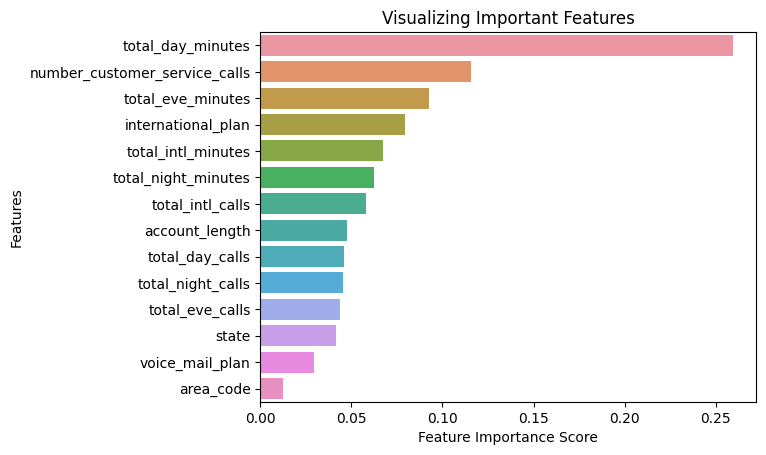

In [26]:
sns.barplot(x=feature_scores, y=feature_scores.index)
# labels to the graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
# title to the graph
plt.title("Visualizing Important Features")
# Visualize
plt.show()

In [ ]:
X_train.dtypes

state                            category
account_length                      int64
area_code                        category
international_plan               category
voice_mail_plan                  category
total_day_minutes                 float64
total_day_calls                     int64
total_eve_minutes                 float64
total_eve_calls                     int64
total_night_minutes               float64
total_night_calls                   int64
total_intl_minutes                float64
total_intl_calls                    int64
number_customer_service_calls       int64
dtype: object

In [27]:
from sklearn.preprocessing import OrdinalEncoder
# Define a list of categorical columns to be encoded
cat_cols = ['international_plan', 'voice_mail_plan', 'area_code']

# OrdinalEncoder class
encoder = OrdinalEncoder()

# Fit the encoder to the categorical columns in the data
encoder.fit(X_train[cat_cols])

# Transform the categorical columns into ordinal encoded columns
X_train[cat_cols] = encoder.transform(X_train[cat_cols])


In [ ]:
clf = RandomForestClassifier(random_state=RANDOM_STATE,criterion='gini',min_impurity_decrease=0,max_features='sqrt')

# fit the model to the training set
clf.fit(X_train, y_train)

# Predict on the test set results

y_pred = clf.predict(X_test)

# Check accuracy score 

print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score: 0.9518


In [28]:
cm = confusion_matrix(y_test, y_pred)

print('Confusion matrix\n\n', cm)

Confusion matrix

 [[717   4]
 [ 37  92]]


In [29]:

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       721
           1       0.96      0.71      0.82       129

    accuracy                           0.95       850
   macro avg       0.95      0.85      0.89       850
weighted avg       0.95      0.95      0.95       850



In [30]:
#GaussianNB

from sklearn.naive_bayes import GaussianNB
# Create  GaussianNB class
gnb = GaussianNB()

# Fit the model to the training data
gnb.fit(X_train, y_train)

# Use the trained model to make predictions on the test data
y_pred = gnb.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)


Accuracy:  0.8494117647058823


In [37]:
#FEATURE SELECTION

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler


pipeline = Pipeline([
    ('scaler', StandardScaler()), # Scale features
    ('feature_selection', SelectKBest(score_func=f_classif, k=10)), # Select top 10 features withatures  top 5 features f1 score is lower so i choose 10
    ('classifier', RandomForestClassifier(n_estimators=100,criterion='gini',max_features='sqrt')) # Train random forest classifier
])

# Fit pipeline
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Print classification report, F1 score and accuracy score
print(classification_report(y_test, y_pred))
print("F1 score: {:.2f}".format(f1_score(y_test, y_pred)))
print("Accuracy score: {:.2f}".format(accuracy_score(y_test, y_pred)))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       721
           1       0.95      0.81      0.87       129

    accuracy                           0.96       850
   macro avg       0.96      0.90      0.92       850
weighted avg       0.96      0.96      0.96       850

F1 score: 0.87
Accuracy score: 0.96


In [ ]:
# HOMEWORK
# 1. TRY DIFFERENT MODELS (RF, ADA, NB, SVC, KNN)
# 2. FEATURE SELECTION (DO IT WITH PIPELINES), IF UNABLE, DO IT MANUALLY:
# 2.1. USE ONLY >0.1 CORRELATED FEATURES
# 2.2. USE SKLEARN SelectKBest
# 3. BONUS: IF YOU THINK IT'S NECESSARY, ADD EDA STEPS AT THE TOP

In [ ]:
print("Vasil Stamenkoski")

Vasil Stamenkoski
